* Data Name : Wili 2018
* Source: Kaggle [https://www.kaggle.com/datasets/sharansmenon/wili-2018?select=data.csv]
* The main language data. Contains about 200k instances for 235 languages



In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
import pickle
import time


## Load Data

In [13]:
main_data = pd.read_csv('data.csv')

In [14]:
main_data.head()

,text,class
0,Klement Gottwaldi surnukeha palsameeriti ning ...,est\n
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",swe\n
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai\n
3,"Après lo cort periòde d'establiment a Basilèa,...",oci\n
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,tha\n


## Data Cleaning
* Remove Escape strings at the end of the Data


In [15]:
def clean_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Parameters: dataframe(pd.DataFrame): Main Downloaded Data

    Return: pd.DataFrame (A Clean Version of Data Frame)
    
    """
    dataframe['class'] = dataframe['class'].apply(lambda x: x[:-1])

    print('Cleaning Completeed')
    return(dataframe)
    
    

## Data PreProcesing
* Select only data label to Afrikaans, Spanish and German only
* Feature Extraction (TF-IDF- Term Frequency-Inverse Document Frequency)

In [16]:
def extract_selected_language(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Parameters: dataframe(pd.DataFrame) -> Main Data Frame containing all Data 

    Returns: pd.DataFrame -> A Dataframe containing only Afrikaans, Spanish, German, Alemannic German

    """
    extracted_data = dataframe[(dataframe['class'] == 'afr') | (dataframe['class'] == 'spa') | (dataframe['class'] == 'als') | (dataframe['class'] == 'deu')]
    print('Succesfully Extracted Data')
    return extracted_data


def save_extracted_data_to_csv(dataframe: pd.DataFrame) -> None:
    """
    Parameters: dataframe(pd.DataFrame) -> Dataframe of already extracted languages

    Save The Data to a csv file
    
    """
    dataframe.to_csv('data_folder/extracted_data.csv', index=False)
    print('Succesfully Saved To Csv')

In [21]:
#Extracting and Saving Data
data = extract_selected_language(clean_data(main_data))
save_extracted_data_to_csv(data)

Cleaning Completeed
Succesfully Extracted Data
Succesfully Saved To Csv


In [80]:
#Preview Extracted Data
extracted_data = pd.read_csv('./data_folder/extracted_data.csv')
extracted_data.head()

,text,class
0,Uf di hitig Greßi isch s schließlig anne 1998 ...,als
1,"En Navidad de 1974, poco después de que interp...",spa
2,1499: D Schlacht im Schwaderloh im Thurgau goh...,als
3,Die geelblom (Cineraria saxifraga) is 'n klein...,afr
4,"Talle van mense, dikwels uit geïsoleerde gemee...",afr


### Data Visualization
* The Class for each category is evenly distributed across with each class having 1000 datapoints

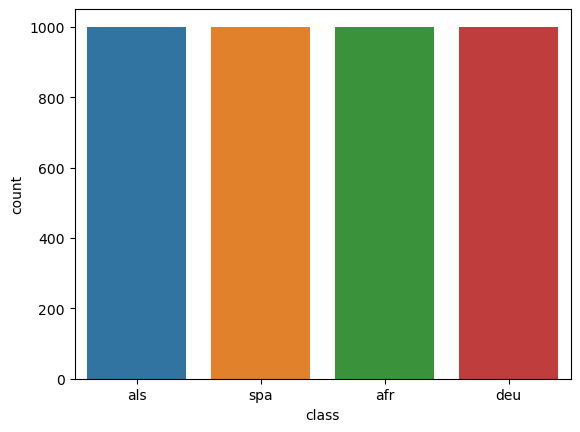

In [77]:
sns.countplot(x= 'class', data = extracted_data)
plt.show()

In [23]:
def feature_extraction_et_label_encoding(dataframe: pd.DataFrame) -> list:
    """
    Parameters:  dataframe: pd.DataFrame -> Data frame of selected language

    Return: A list [text_vectors, language_label, language_label_mapping]

    Receive a Dataframe and perform the following operations
    * Split to Features and Labels
    * Perform Labeel Encoding on the Label Section
    * Perform Feature Extarction usinf TfIDF on the feature Section
    * Extract Label Mapping
    * Return A list Containing The Vectors, Labels and Label Mapping
    
    """

    # Split Data to Texts and Labels
    texts = dataframe.text
    language_label = dataframe['class']
    
    #Encoding
    label_encoder = LabelEncoder() # initialize Encoder
    language_label= label_encoder.fit_transform(language_label)
    language_label_mapping = dict(zip(label_encoder.classes_,
                                     label_encoder.transform(label_encoder.classes_)))

    print('Label Encoding Completeed')

    # Save Encoding Dictionary
    with open('pickles/language_label_mapping.pkl','wb') as file0:
        pickle.dump(language_label_mapping, file0)
    
    #Vectorization
    tfidf_vectorizer = TfidfVectorizer() # Initialize the Vectorizer

    tfidf_text_vectors = tfidf_vectorizer.fit_transform(texts).toarray()
    print('Vectorization Complete')
    
    # Save Vectorizer
    with open('pickles/tfidf_vectorizer.pkl','wb') as file:
        pickle.dump(tfidf_vectorizer, file)
    print('Vectorizer Saved to pickles folder')
    
    print('Encoding And Preprocessing Completed')
    return [tfidf_text_vectors,language_label,language_label_mapping]

In [24]:
#Encoding and Vectorizing
vectors, label, mapping = feature_extraction_et_label_encoding(extracted_data)

Label Encoding Completeed
Vectorization Complete
Vectorizer Saved to pickles folder
Encoding And Preprocessing Completed


### Spliting Data

In [67]:
def split_data(vectors: pd.Series, label: pd.Series) -> tuple:
    """
    Parameters vectors(pd.Series) label(pd.Series)

    Return: A tupple of the split features

    Split Data into Train and test features with 30 Percent to test and 70 to training
    
    """
    train_features, test_val_features, train_label, test_val_label = train_test_split(vectors,
                                                                              label,
                                                                              test_size=0.30, 
                                                                              random_state=3)

    test_features, val_features, test_label, val_label = train_test_split(test_val_features,
                                                                              test_val_label,
                                                                              test_size=0.33, 
                                                                              random_state=3)
    print('Data Splitted successfully to Training, Testing and Validation set')
    return train_features,test_features,val_features,train_label,test_label,val_label
    


In [68]:
def train_models(train_features: pd.Series,
                 test_features: pd.Series,
                 train_label: pd.Series,
                 test_label: pd.Series):

    """
    Parameters : 
    train_features -> features to be use in training (pd.Series)
    test_features -> features for training (pd.Series)
    train_labels -> training labels (pd.Series)
    test_labels -> testing labels (pd.Series)
    Return A tupple for the prediction of all Models

    Train 3 Language Identification Models
    
    """
    #Models Initialization
    naive_bayes_model = MultinomialNB() # Naive Bayes
    logistic_regression_model = LogisticRegression() # Logistic Regression
    random_forest_classifier_model = RandomForestClassifier() # Random Forest Classifier
    print('Models Initialization Completed')
    

    #Models Training
    start_time = time.time()
    naive_bayes_model.fit(train_features, train_label)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Naive Bayes Completed time taken is {time_taken:.2f} seconds')
    
    start_time = time.time()
    logistic_regression_model.fit(train_features, train_label)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Logistic Regression Completed time taken is {time_taken:.2f} seconds')


    start_time = time.time()
    random_forest_classifier_model.fit(train_features, train_label)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Random Forest Completed time taken is {time_taken:.2f} seconds')
    
    print('Models Training Completed')

    #Models Predictions
    naive_bayes_model_prediction = naive_bayes_model.predict(test_features)
    logistic_regression_model_prediction = logistic_regression_model.predict(test_features)
    random_forest_classifier_model_prediction = random_forest_classifier_model.predict(test_features)
    print('Models Predictions Complete')


    return naive_bayes_model_prediction, logistic_regression_model_prediction, random_forest_classifier_model_prediction


    
    

In [69]:

def evaluate_models(test_label: pd.Series, 
                    naive_bayes_prediction: pd.Series, 
                    logistic_regression_prediction: pd.Series, 
                    random_forest_prediction: pd.Series):
    
    """
    Parameters:
    - test_label: True labels for the test set (pd.Series)
    - naive_bayes_prediction: Predictions from the Naive Bayes model (pd.Series)
    - logistic_regression_prediction: Predictions from the Logistic Regression model (pd.Series)
    - random_forest_prediction: Predictions from the Random Forest model (pd.Series)
    
    Return:
    - Prints evaluation metrics including F1-score, Recall, Precision, and Classification Report for all models.
    """
    
    # Model Evaluation: Naive Bayes
    print('Naive Bayes Model Evaluation:')
    print(f'F1-Score: {f1_score(test_label, naive_bayes_prediction, average="weighted"):.4f}')
    print(f'Recall: {recall_score(test_label, naive_bayes_prediction, average="weighted"):.4f}')
    print(f'Precision: {precision_score(test_label, naive_bayes_prediction, average="weighted"):.4f}')
    print('Classification Report:\n', classification_report(test_label, naive_bayes_prediction))
    
    print('-' * 50)
    
    # Model Evaluation: Logistic Regression
    print('Logistic Regression Model Evaluation:')
    print(f'F1-Score: {f1_score(test_label, logistic_regression_prediction, average="weighted"):.4f}')
    print(f'Recall: {recall_score(test_label, logistic_regression_prediction, average="weighted"):.4f}')
    print(f'Precision: {precision_score(test_label, logistic_regression_prediction, average="weighted"):.4f}')
    print('Classification Report:\n', classification_report(test_label, logistic_regression_prediction))
    
    print('-' * 50)
    
    # Model Evaluation: Random Forest
    print('Random Forest Model Evaluation:')
    print(f'F1-Score: {f1_score(test_label, random_forest_prediction, average="weighted"):.4f}')
    print(f'Recall: {recall_score(test_label, random_forest_prediction, average="weighted"):.4f}')
    print(f'Precision: {precision_score(test_label, random_forest_prediction, average="weighted"):.4f}')
    print('Classification Report:\n', classification_report(test_label, random_forest_prediction))

    print('Evaluation Completed')


In [70]:
#Split Data
train_features,test_features,val_features,train_label,test_label,val_label = split_data(vectors,label)


Data Splitted successfully to Training, Testing and Validation set


In [58]:
#Train Models
naive_bayes_pred, logistic_regression_pred, random_forest_pred = train_models(train_features,
                                                                              test_features,
                                                                              train_label,
                                                                              test_label)

Models Initialization Completed
Naive Bayes Completed time taken is 19.05 seconds
Logistic Regression Completed time taken is 292.10 seconds
Random Forest Completed time taken is 75.34 seconds
Models Training Completed
Models Predictions Complete


In [ ]:
# Call evaluate function
evaluate_models(test_label, naive_bayes_pred, logistic_regression_pred, random_forest_pred)

In [73]:
def grid_search_tuning(train_features: pd.Series,
                       test_features: pd.Series,
                       val_features: pd.Series,
                       train_label: pd.Series,
                       test_label: pd.Series,
                       val_label: pd.Series):
    """
    Perform hyperparameter tuning for Naive Bayes, Logistic Regression, and Random Forest models using GridSearchCV.
    
    Parameters:
    - train_features: Training features (pd.Series)
    - train_label: Training labels (pd.Series)
    - test_features: Testing features (pd.Series)
    - test_labels: Testing Labels (pd.Series)
    - val_features: Validation features (pd.Series)
    - val_label: Validation Labels (pd.Series)
    Returns:
    - Best hyperparameters for each model
    """
    
    # Naive Bayes Hyperparameter Tuning
    naive_bayes = MultinomialNB()
    naive_bayes_params = {
        'alpha': [0.1, 0.5, 1.0],
        'fit_prior': [True, False] # hyperparameter values for Naive Bayes
    }
    print('Starting HyperParameter Tuning')
    start_time = time.time()
    naive_bayes_grid = GridSearchCV(estimator=naive_bayes,
                                    param_grid=naive_bayes_params,
                                    cv=5,
                                    scoring='f1_weighted')
    
    naive_bayes_grid.fit(train_features, train_label)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Grid Search HyperParameter Tuning Completed time taken is {time_taken:.2f} seconds')
    naive_bayes_grid_predictions = naive_bayes_grid.predict(test_features)
    print(f'Best Params for Naive Bayes: {naive_bayes_grid.best_params_}')

    print('Naive Bayes Model Grid Search Evaluation On Testing Subset:')
    print(f'F1-Score: {f1_score(test_label, naive_bayes_grid_predictions, average="weighted"):.4f}')
    print(f'Recall: {recall_score(test_label, naive_bayes_grid_predictions, average="weighted"):.4f}')
    print(f'Precision: {precision_score(test_label, naive_bayes_grid_predictions, average="weighted"):.4f}')
    print('Classification Report:\n', classification_report(test_label, naive_bayes_grid_predictions))

    
    naive_bayes_grid_predictions_validation = naive_bayes_grid.predict(val_features)
    print('Naive Bayes Model Grid Search Evaluation On Validation Subset:')
    print(f'F1-Score: {f1_score(val_label, naive_bayes_grid_predictions_validation, average="weighted"):.4f}')
    print(f'Recall: {recall_score(val_label, naive_bayes_grid_predictions_validation, average="weighted"):.4f}')
    print(f'Precision: {precision_score(val_label, naive_bayes_grid_predictions_validation, average="weighted"):.4f}')
    print('Classification Report:\n', classification_report(val_label, naive_bayes_grid_predictions_validation))

    with open('pickles/final_naivebaye_model.pkl','wb') as file:
        pickle.dump(naive_bayes_grid, file)

    print('Model Saved To Pickle Folder')
    
   


In [74]:
grid_search_tuning(train_features, test_features, val_features,train_label, test_label,val_label)

Starting HyperParameter Tuning
Grid Search HyperParameter Tuning Completed time taken is 191.10 seconds
Best Params for Naive Bayes: {'alpha': 0.1, 'fit_prior': True}
Naive Bayes Model Grid Search Evaluation On Testing Subset:
F1-Score: 0.9901
Recall: 0.9900
Precision: 0.9904
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      0.97      0.98       198
           2       0.96      1.00      0.98       187
           3       1.00      1.00      1.00       207

    accuracy                           0.99       804
   macro avg       0.99      0.99      0.99       804
weighted avg       0.99      0.99      0.99       804

Naive Bayes Model Grid Search Evaluation On Validation Subset:
F1-Score: 1.0000
Recall: 1.0000
Precision: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1      

In [2]:
spanish = ['hola, como estas?', 'Buenos dias', 'Por favor, donde esta','Adios, hasta manana']
german = ['Guten Morgen','Wie geht es ihnen','Wo ist die Toilette?','Auf wiedersehen']
afrikaans = ['goeie more','hoe gaan dit met jou?','waar is die badkamer?','Ek verstaan nie']

In [5]:
with open('pickles/final_naivebaye_model.pkl','rb') as file:
    classifier = pickle.load(file)

with open('pickles/tfidf_vectorizer.pkl','rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('pickles/language_label_mapping.pkl','rb') as file:
    mapping = pickle.load(file)



### Testing Model
- Test the model on user written phrases

In [19]:
def testing_model(phrases:list, language:str)-> int:
    score = 0

    for phrase in phrases:
        vectors = tfidf_vectorizer.transform([phrase]).toarray()
        prediction = classifier.predict(vectors)[0]
        
        if mapping[language] == prediction:
            score += 1
        else:
            continue

    print(f'Score is = {score}/4')

In [29]:
testing_model(afrikaans,'afr')

Score is = 4/4


In [33]:
classifier.predict_proba(vectors)

array([0.00958062, 0.01000322, 0.0097704 , 0.97064575])

In [25]:
print(mapping)

{'afr': 0, 'als': 1, 'deu': 2, 'spa': 3}
